<a href="https://colab.research.google.com/github/nathalyAlarconT/GenAI_Workshops/blob/main/FunctionCalling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini's Power for Tourism Apps: A Function Calling Tutorial

In [ ]:
!pip install --upgrade google-cloud-aiplatform --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.6 MB/s eta 0:00:00


**Function Calling** Is a Gemini Functionality, where we can deliver a set of defined functions and according to the prompt received, Gemini will decide if it should use the provided defined function(s) to generate the response. The final response will be also provided in a friendly natural language.



You can find more information of Function calling here: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling


**Goal of the tutorial**

In this tutorial, we will create a **Tourism tool** where we will allow the users to query the weather for future days in a particular place. If the prompt doesn't contain a question related to the weather, Gemini will generate it's own response.


# Functions definition

In [ ]:
# Required Libraries
import requests
import json
import pandas as pd
# import plotly.express as px

## API to be used
We will call 2 different methods from the following Weather API : https://open-meteo.com



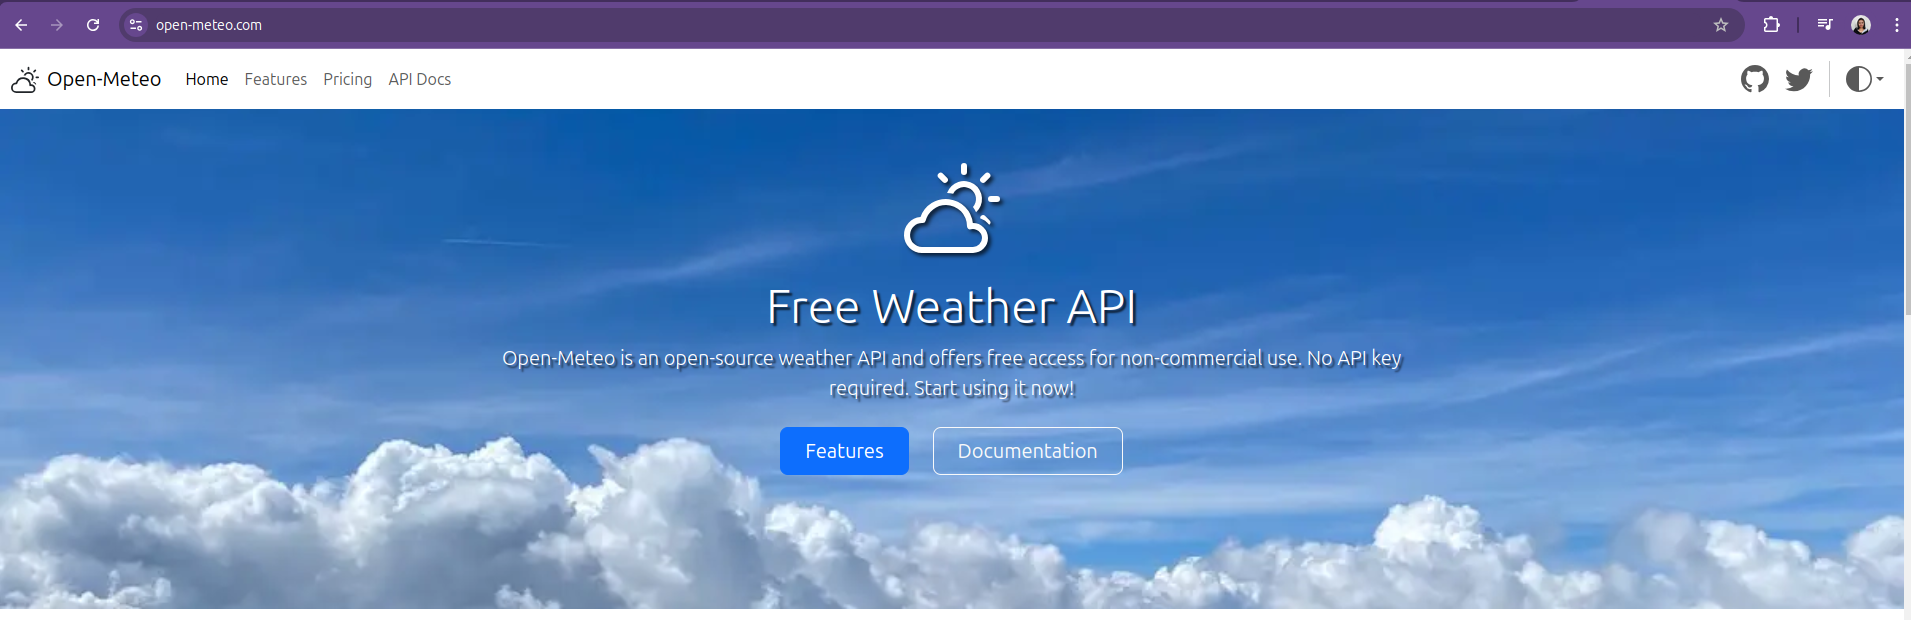

We will use the following methods:


1.   **Geocoding API** : https://open-meteo.com/en/docs/geocoding-api

      This method will receive the name of a particular location and will return information such as latitude, longitude, population among others.

2.   **Weather Forecast API** : https://open-meteo.com/en/docs
      This method will receive latitude and longitude for a particular place and will return the forecasted weather



In [ ]:
def get_location_data(location_name):
  """Retrieves location data from the Open-Meteo Geocoding API.

  This function takes a location name as input and returns
  a JSON object containing location data from the Open-Meteo API.

  Args:
    location_name: The name of the location to search for. eg. "La Paz, Bolivia"

  Returns:
    A JSON object containing location data.
  """

  location_url = f"https://geocoding-api.open-meteo.com/v1/search?name={location_name}&count=10&language=en&format=json"
  response = requests.get(location_url)
  response_json = json.loads(response.text)
  return response_json


Sample Call and result:
```
get_location_data("La Paz, Bolivia")
```

API Response format:
```
{'results': [{'id': 3911925,
   'name': 'La Paz',
   'latitude': -16.5,
   'longitude': -68.15,
   'elevation': 3782.0,
   'feature_code': 'PPLG',
   'country_code': 'BO',
   'admin1_id': 3911924,
   'timezone': 'America/La_Paz',
   'population': 812799,
   'country_id': 3923057,
   'country': 'Bolivia',
   'admin1': 'Departamento de La Paz'}],
 'generationtime_ms': 5.160928}
```



In [ ]:
def get_weather_forecast(latitude, longitude, timezone = "America/La_Paz", forecast_days = 3):
  """Retrieves weather forecast data from the Open-Meteo Weather API.

  This function takes latitude, longitude, timezone, and forecast days as input,
  and returns a json object containing the weather forecast data.

  Args:
      latitude: The latitude of the location.
      longitude: The longitude of the location.
      timezone: The timezone of the location (default: "America/La_Paz").
      forecast_days: The number of forecast days (default: 3).

  Returns:
      A Json object containing the weather forecast data.
  """


  weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m&timezone={timezone}&forecast_days={forecast_days}"
  response = requests.get(weather_url)
  response_json = json.loads(response.text)

  # Basic Transformation of results
  df = pd.DataFrame()
  df["DateTime"] = response_json["hourly"]["time"]
  df["Temperatura"] = response_json["hourly"]["temperature_2m"]

  # px.line(df, x="DateTime", y="Temperatura")
  return df.to_json(orient="records")

Sample Call and result:
```
get_weather_forecast(latitude = "-16.5", longitude="-68.15")
```

API Response format:
```
[{"DateTime":"2024-08-28T00:00","Temperatura":5.1},
{"DateTime":"2024-08-28T01:00","Temperatura":5.9},
{"DateTime":"2024-08-28T02:00","Temperatura":5.3},
{"DateTime":"2024-08-28T03:00","Temperatura":4.9},
{"DateTime":"2024-08-28T04:00","Temperatura":5.3},
{"DateTime":"2024-08-28T05:00","Temperatura":4.7},
{"DateTime":"2024-08-28T06:00","Temperatura":4.4},
...]
```



# Vertex AI Configuration

In [ ]:
# Required Libraries
import vertexai

from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    GenerationConfig,
    Part,
    Tool,
)

### GCP Project Settings

In [ ]:
# Let's authenticate our user
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
from google.colab import userdata

# Replace here your GCP PROJECT NAME and PROJECT LOCATION
GCP_PROJECT = userdata.get('GCP_Project')
GCP_PROJECT_LOCATION = userdata.get('GCP_Project_location')

vertexai.init(project=GCP_PROJECT, location=GCP_PROJECT_LOCATION)

# Function Calling Configuration

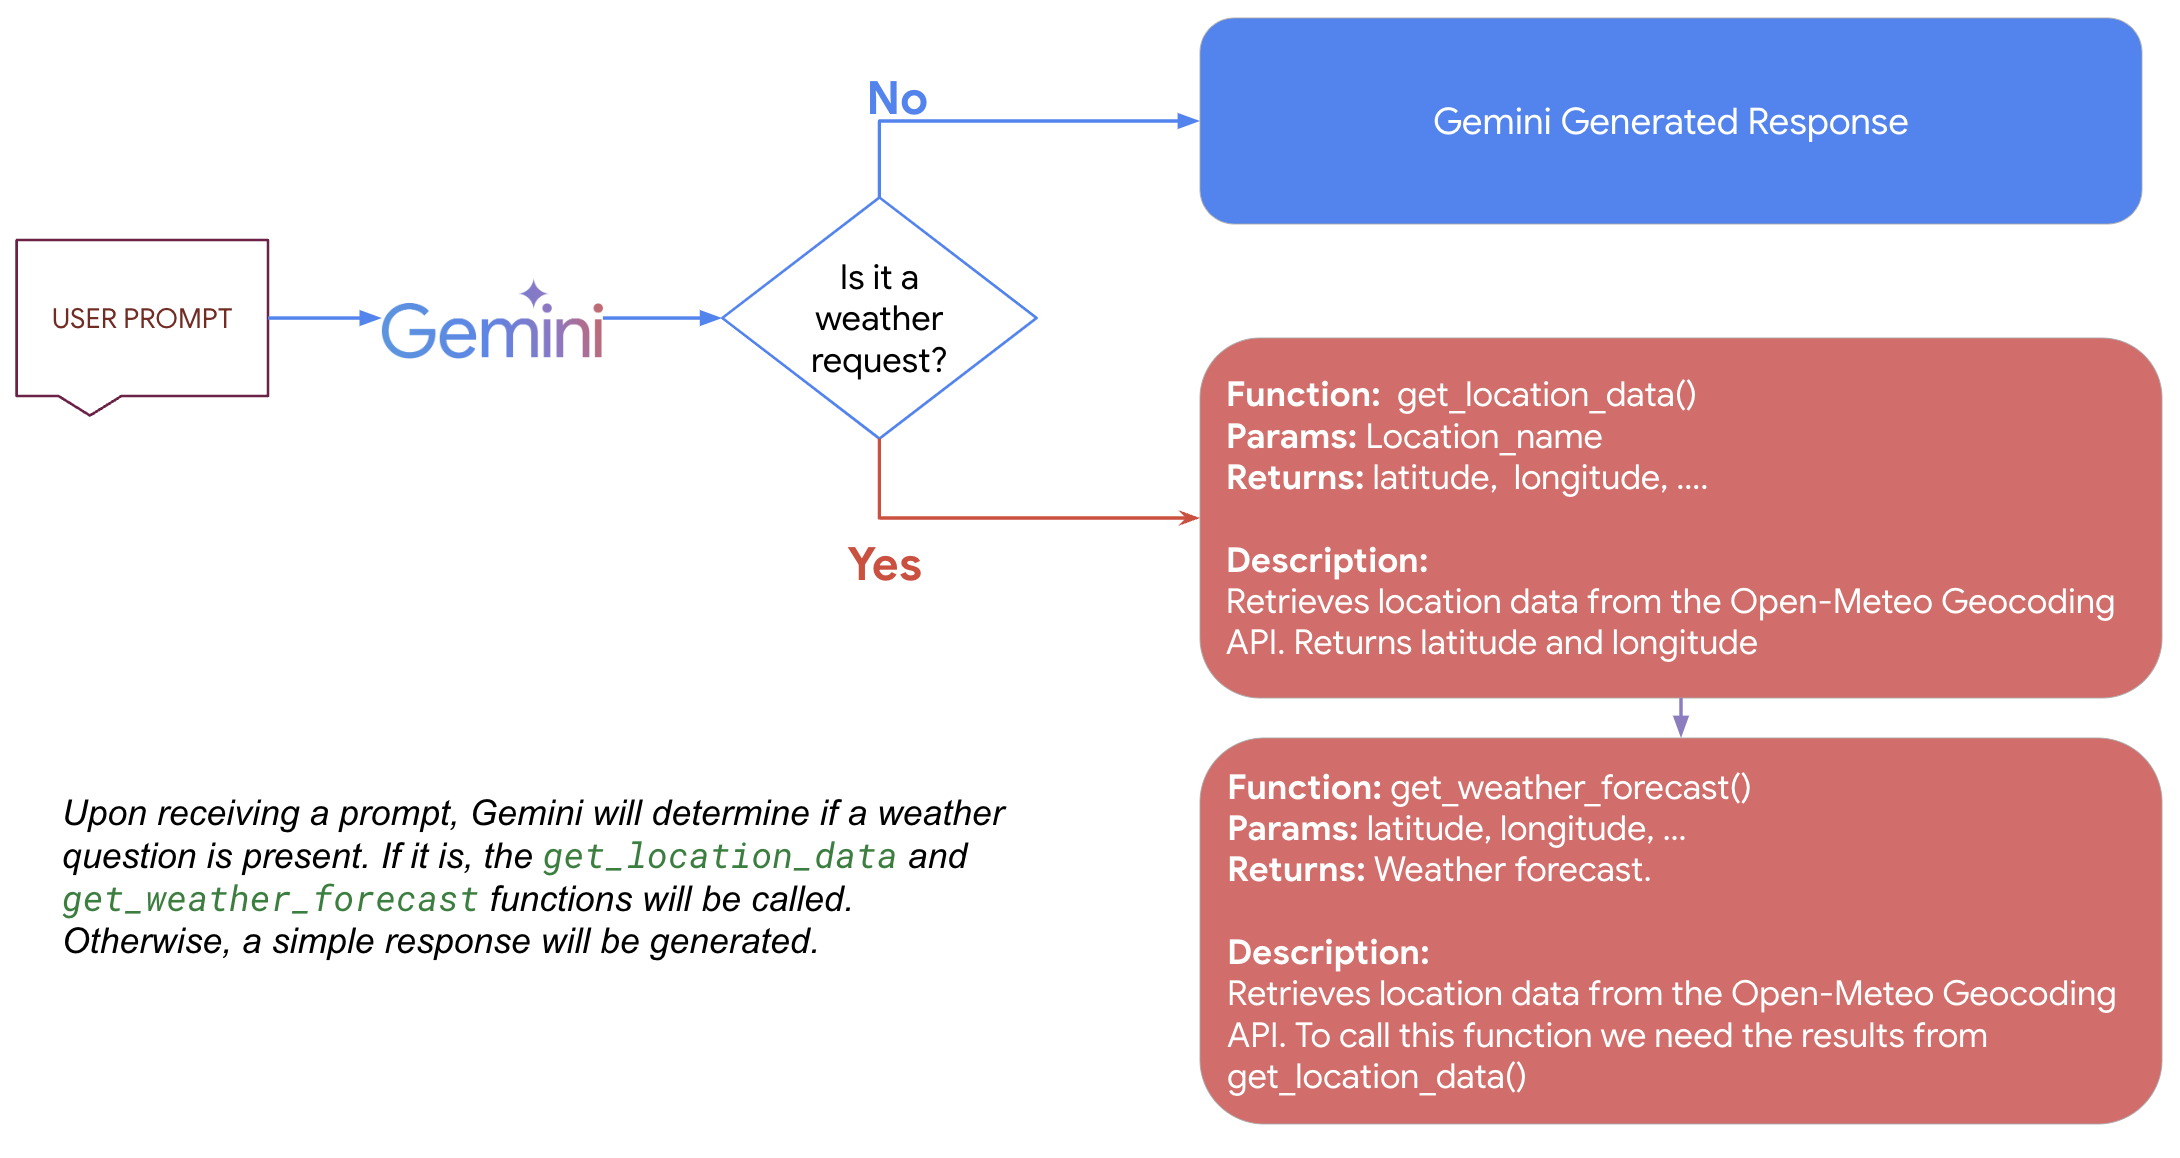

Let's define **get_location_data** and **get_weather_forecast** functions as Functions to be used with Gemini.

It is important to define the function name and the parameters list and purpose.



In [ ]:
# Function Declaration for get_location_data

get_location_data_func = FunctionDeclaration(
    name="get_location_data",
    description="Get latitude, longitude and population of a particular location. ",
    parameters={
      "type": "object",
      "properties": {
          "location_name": {
              "type": "string",
              "description": "Name of a country or city. If available provide: City, Country"
          },
      },
      "required": [
              "location_name"
      ]
    },
)


In [ ]:
# Function Declaration for get_weather_forecast

get_weather_forecast_func = FunctionDeclaration(
    name="get_weather_forecast",
    description="Provide the hourly forecasting of weather for a particular place based on latitud and longitud",
    parameters={
      "type": "object",
      "properties": {
          "latitude": {
              "type": "string",
              "description": "Latitude of the location desired, this can come from get_location_data function."
          },
          "longitude": {
              "type": "string",
              "description": "Longitude of the location desired, this can come from get_location_data function."
          },
          "timezone": {
              "type": "string",
              "description": "Timezone for the hourly forecast in format similar to: America/La_Paz, If not specified, this can come from get_location_data function."
          },
          "forecast_days": {
              "type": "string",
              "description": "Amount of days to forecast weather"
          },
      },
      "required": [
              "latitude", "longitude"
      ]
    },
)

Now let's create a Tool object were we will add all the functions defined.

In [ ]:
tourism_tool = Tool(function_declarations=[get_location_data_func, get_weather_forecast_func])

## Gemini Flash with Function Calling Execution

We configure Gemini Flash model and as an extra parameter, we will send the Tools defined previously

In [ ]:
model = GenerativeModel("gemini-1.5-flash-001", generation_config=GenerationConfig(temperature=0), tools=[tourism_tool])

In [ ]:
chat = model.start_chat()

### Auxiliar functions to call Gemini and Function Calling

In [ ]:
def call_gemini_api(prompt):
  """Calls the Gemini API with the given prompt.

  Args:
    prompt: The prompt to send to the Gemini API.

  Returns:
    The text response from the Gemini API.
  """

  # Send the prompt to the Gemini API
  response = chat.send_message(prompt)


  # Check if the response contains a function call
  if response.candidates[0].content.parts[0].function_call:
    # print("Function calling")
    # Extract the text from the model response
    function_calling_result = call_a_function(response)
    # Return the final text from the function call
    return function_calling_result.text

  else:
    # print("Regular model call")
    # Return the text from the model response for a regular call
    # Without function calling.
    return response.text


In [ ]:
def call_a_function(response):
    """
    This function parses a response object containing a function call,
    constructs the function call string, executes it using eval,
    and returns the API response or makes another function call if necessary.

    Args:
        response: A response object containing the function call information.

    Returns:
        The API response or the response from another function call (recursive).
    """


    # Extract the function name from the response object
    func_name = response.candidates[0].content.parts[0].function_call.name
    calling_parameters_function = ""


    # Loop through function call arguments and construct the argument string
    for param_name in response.candidates[0].content.parts[0].function_call.args:
      param_value = response.candidates[0].content.parts[0].function_call.args[param_name]
      calling_parameters_function += f"{param_name} = '{param_value}',"

    # Remove the trailing comma from the argument string
    # and build final function call statement
    calling_function_string = f"{func_name}({calling_parameters_function[:-1]})"
    print(calling_function_string)

    # Execute the call to the api within the defined function
    response_api = eval(calling_function_string)
    print(response_api)

    # Return the API response back to Gemini, so it can generate a model response or request another function call
    response = chat.send_message(
        Part.from_function_response(
            name= func_name,
            response={
                "content": response_api,
            },
        ),
    )

    # print(response)
    # Check if the response contains another function call
    if response.candidates[0].content.parts[0].function_call:
      # Make another recursive function call if there's another function call
      response_function = call_a_function(response)
      return response_function
    else:
      # If no more function calls, return the response
      # print("No more API calls")
      return response

# Prompt Execution

Here we mention the name of a location, so Gemini will try to get to call get_location_data function. As no relevant info is found, Gemini generates it's own result.

In [ ]:
prompt = """
What are the main places to visit in Bolivia?`
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

get_location_data(location_name = 'Bolivia')
{'results': [{'id': 3923057, 'name': 'Bolivia', 'latitude': -17.0, 'longitude': -65.0, 'elevation': 233.0, 'feature_code': 'PCLI', 'country_code': 'BO', 'timezone': 'America/La_Paz', 'population': 11353142, 'country_id': 3923057, 'country': 'Bolivia'}, {'id': 4456615, 'name': 'Bolivia', 'latitude': 34.06767, 'longitude': -78.14833, 'elevation': 12.0, 'feature_code': 'PPLA2', 'country_code': 'US', 'admin1_id': 4482348, 'admin2_id': 4457580, 'admin3_id': 4495336, 'timezone': 'America/New_York', 'population': 151, 'postcodes': ['28422'], 'country_id': 6252001, 'country': 'United States', 'admin1': 'North Carolina', 'admin2': 'Brunswick', 'admin3': 'Town Creek Township'}, {'id': 3567086, 'name': 'Bolivia', 'latitude': 22.08397, 'longitude': -78.33884, 'elevation': 13.0, 'feature_code': 'PPLA2', 'country_code': 'CU', 'admin1_id': 3564175, 'timezone': 'America/Havana', 'country_id': 3562981, 'country': 'Cuba', 'admin1': 'Provincia de Ciego de Ávil

As we identify Uyuni as a place of interest, let's ask for the weather. In this case, Gemini needs to use both functions: get_location_data and get_weather_forecast to provide an answer.

In [ ]:
prompt = """
How will the weather be in Uyuni?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

get_location_data(location_name = 'Uyuni, Bolivia')
{'results': [{'id': 3901903, 'name': 'Uyuni', 'latitude': -20.45967, 'longitude': -66.82503, 'elevation': 3673.0, 'feature_code': 'PPL', 'country_code': 'BO', 'admin1_id': 3907580, 'timezone': 'America/La_Paz', 'population': 10293, 'country_id': 3923057, 'country': 'Bolivia', 'admin1': 'Departamento de Potosí'}, {'id': 3901902, 'name': 'Uyuni', 'latitude': -21.12149, 'longitude': -66.49024, 'elevation': 4037.0, 'feature_code': 'PPL', 'country_code': 'BO', 'admin1_id': 3907580, 'timezone': 'America/La_Paz', 'country_id': 3923057, 'country': 'Bolivia', 'admin1': 'Departamento de Potosí'}, {'id': 3901904, 'name': 'Uyuni', 'latitude': -19.71715, 'longitude': -68.12159, 'elevation': 3787.0, 'feature_code': 'PPL', 'country_code': 'BO', 'admin1_id': 3909233, 'timezone': 'America/La_Paz', 'country_id': 3923057, 'country': 'Bolivia', 'admin1': 'Oruro'}, {'id': 3901905, 'name': 'Uyuni', 'latitude': -19.4491, 'longitude': -64.83571, 'elevation':

Now let's make a generic question. Gemini won't call any function and will generate the response.

In [ ]:
prompt = """
What clothes do you suggest to wear in a place with -2 degrees Celsius ?
"""

response_gemini = call_gemini_api(prompt)
print("-------------------")
print(response_gemini)

-------------------
To stay warm and comfortable in -2 degrees Celsius, you'll need to layer up! Here's a suggested outfit:

**Base Layer:**

* **Thermal underwear:** This is essential for trapping heat close to your body. Choose a moisture-wicking fabric like merino wool or synthetic fleece.

**Mid Layer:**

* **Fleece jacket:** A fleece jacket provides excellent insulation and is lightweight and breathable.

**Outer Layer:**

* **Waterproof and windproof jacket:** This is crucial for protecting you from the elements. Look for a jacket with a hood and taped seams for added protection.

**Other Essentials:**

* **Warm hat:** A hat will help prevent heat loss from your head. Choose a hat made of wool or fleece.
* **Gloves:**  Wool or fleece gloves will keep your hands warm. Consider waterproof gloves if you'll be exposed to snow or rain.
* **Warm socks:** Wool or synthetic socks will keep your feet warm and dry.
* **Scarf:** A scarf will help protect your neck from the cold.

**Addition

--------------------------



*Google AI/ML Developer Programs team supported this work by providing Google Cloud Credits*